# Analiza Szeregów Czasowych

In [6]:
import pandas as pd
import numpy as np
import statsmodels.api as sm
import matplotlib.pyplot as plt
import seaborn as sb
import os
import progressbar
# py -m pip install progressbar2
# py -m pip install openpyxl
# py -m pip install statsmodels
# py -m pip install seaborn
import openpyxl as xl

In [20]:
# generowanie danych dla procesu ARIMAX(p, d, q, X)

# d - stopień integracji
# q - opóźnienie dla procesu średniej ruchomej
# X - dodatkowe zmienne objaśniające - więc jest nie tylko egzogeniczna - model dynamiczny
# nie bierzemy pod uwagę sezonowości (ale ARIMAX dopuszcza taką opcję gdybyśmy chcieli)

T = 600    # liczba obserwacji na y do wygenerowania
x = np.random.normal(1.5, 1, (T,1))     # pierwsza zmienna to wartość oczekiwana, druga to odchylenie standardowe, trzecia to wymiar tablicy która ma być zwrócona - T x 1

er = np.random.normal(0, 1, (T,1))   # generowanie błędów
print(er.mean(), er.std())
er = (er - er.mean()) / er.std()    # poprawa na "małą" próbę (standaryzacja) - niby nie jest to mała próba (2000), ale chcemy poprawić charakterystyki szumu, żeby nie miały przełożenia na wyniki
print(er.mean(), er.std())

y = np.zeros([T,1])
y_lag = 2

for i in range(0, T, 1):    # ostatnia zmienna to co ile ma skakać iterator, u nas skacze o 1
    y[i] = 2 + 0.8 * x[i] + 0.3 * y_lag + er[i]     # 0.3 * y_lag --- opóźnienie, inaczej pamięć procesu; 0.3*... - procest stacjonarny; gdyby było 1*... - proces niestacjonarny
    y_lag = y[i]

print(x.shape, y.shape)     # wymiary: T x 1, T x 1

-0.07927649359713558 0.9599632121168508
-1.5543122344752193e-17 1.0
(600, 1) (600, 1)


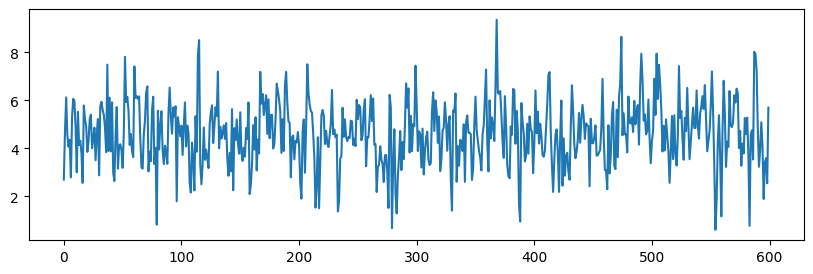

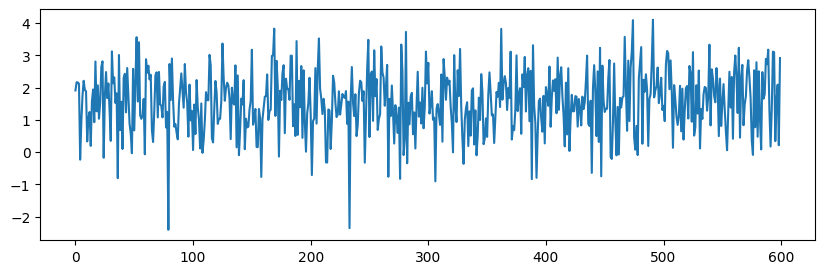

In [21]:
plt.rc('figure', figsize = (10,3))
plt.plot(y)
plt.show()
plt.plot(x)

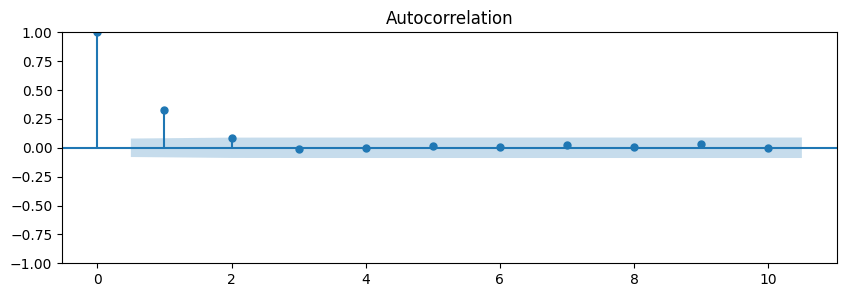

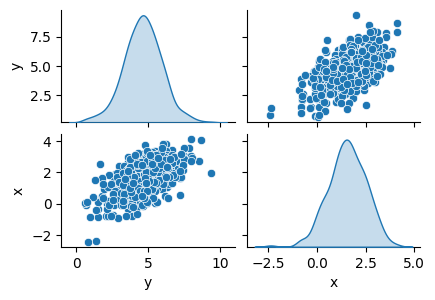

In [22]:
sm.graphics.tsa.plot_acf(y, lags = 10)
# zerowy lag to autokorelacja samego ze sobą - zawsze wystrzeliwuje do 1
# dla tego zestawu danych: może wyjść optymalne AR(2)

#wykres rozrzutu
sb.pairplot(pd.DataFrame(np.c_[y,x], columns = ['y','x']), kind = 'scatter', diag_kind = 'kde', height = 1.5, aspect = 1.5)

### Testy stacjonarności

In [23]:
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.stattools import kpss

adf_y = adfuller(y)
kps_y = kpss(y)

print('Test stacjonarnosci ADF: ', adf_y[0], adf_y[1])
print('Test stacjonarnosci KPSS: ', kps_y[0], kps_y[1])
# faktyczne p-value większe od zwróconego - brak podstaw do odrzucenia niestacjonarności procesu

Test stacjonarnosci ADF:  -17.448472551658195 4.667029862406428e-30
Test stacjonarnosci KPSS:  0.17174690227805917 0.1


C:\Users\en-A009-27\AppData\Local\Temp\ipykernel_16064\1995858202.py:5: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  kps_y = kpss(y)


#### Sprawdziliśmy stacjonarność procesu, przystępujemy więc do estymacji

(Istnieje pakiet automatyzujący - autoarima)

Jeśli wiemy że proces jest stacjonarny to nie robimy b. d wtedy robimy jedno

In [24]:
mruns = 4*2*3*2   #AR(0-3) --> 4; diff = {0,1} --> 2; MA(0-2) --> 3; const = {0,1} --> 2
#a*b*c*d


mybar = progressbar.ProgressBar(max_value = mruns)

mycount = 0

BIC = float('inf')   # wartość początkowa BIC

for a in range(4):
    for b in range(2):
        for c in range(3):
            for d in range(2):
                model = sm.tsa.SARIMAX(y, exog = x, order = (a,b,c), trend = [d,0,0,0])
                res = model.fit(maxiter = 100, method = 'powell', disp = False)
                if res.bic < BIC:
                    BIC = res.bic
                    winner = res
                mycount += 1
                mybar.update(mycount)

winner.summary()

  0% (0 of 48) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
  4% (2 of 48) |#                        | Elapsed Time: 0:00:00 ETA:   0:00:02
  6% (3 of 48) |#                        | Elapsed Time: 0:00:00 ETA:   0:00:03
  8% (4 of 48) |##                       | Elapsed Time: 0:00:00 ETA:   0:00:04
 10% (5 of 48) |##                       | Elapsed Time: 0:00:00 ETA:   0:00:04
 12% (6 of 48) |###                      | Elapsed Time: 0:00:00 ETA:   0:00:05
 14% (7 of 48) |###                      | Elapsed Time: 0:00:00 ETA:   0:00:05
 16% (8 of 48) |####                     | Elapsed Time: 0:00:00 ETA:   0:00:04
 18% (9 of 48) |####                     | Elapsed Time: 0:00:01 ETA:   0:00:04
 20% (10 of 48) |#####                   | Elapsed Time: 0:00:01 ETA:   0:00:04
 22% (11 of 48) |#####                   | Elapsed Time: 0:00:01 ETA:   0:00:04
 25% (12 of 48) |######                  | Elapsed Time: 0:00:01 ETA:   0:00:04
 27% (13 of 48) |######                 

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                  600
Model:               SARIMAX(1, 0, 0)   Log Likelihood                -869.342
Date:                Tue, 15 Apr 2025   AIC                           1746.684
Time:                        14:09:58   BIC                           1764.272
Sample:                             0   HQIC                          1753.531
                                - 600                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      2.4954      0.154     16.154      0.000       2.193       2.798
x1             0.7045      0.041     17.001      0.000       0.623       0.786
ar.L1          0.2929      0.040      7.353      0.000       0.215       0.371
sigma2         1.0603      0.056     18.901      0.000       0.950       1.170
===================================================================================
Ljung-Box (L1) (Q):                   0.02   Jarque-Bera (JB):                 3.88
Prob(Q):                              0.90   Prob(JB):                         0.14
Heteroskedasticity (H):               1.19   Skew:                            -0.01
Prob(H) (two-sided):                  0.21   Kurtosis:                         3.39
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""